HL5 node: 0
HL5 node: 1
HL5 node: 2
HL5 node: 3


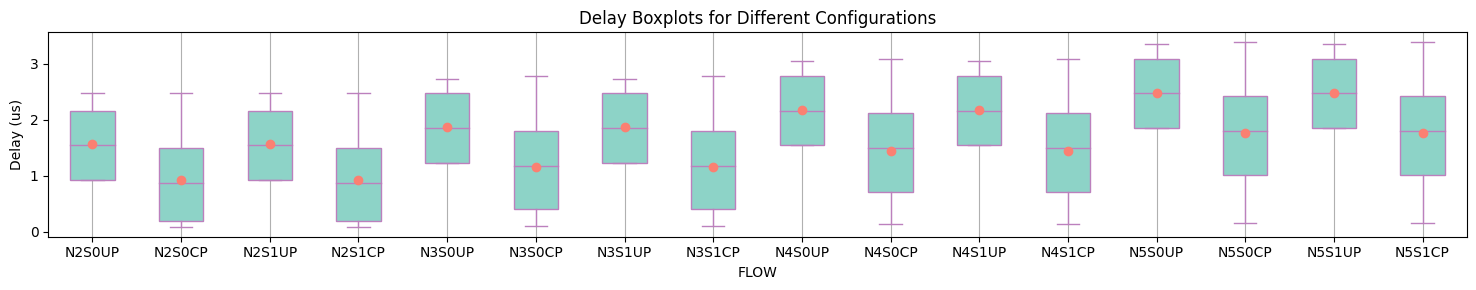

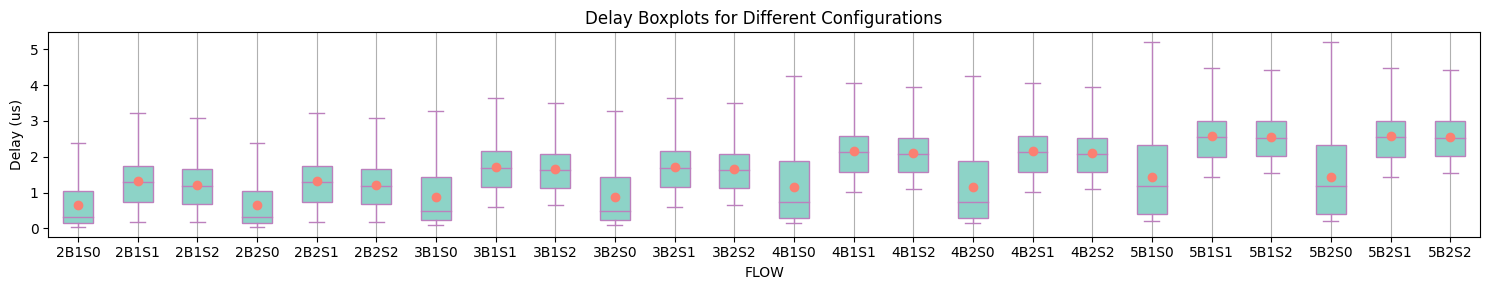

In [5]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
folder = "./sim_results/AllUp/"
# Set a custom color palette
colors = plt.cm.Set3.colors
plt.rcParams["figure.autolayout"] = True
# Open the JSON file and load the data
with open("./scratch/hl4hl5ex.json") as json_file:
    data = json.load(json_file)
delay = []
# Access the data
folder_name = data["FolderName"]
enable_hqos = data["EnableHQoS"]
totflows = 0

# Generate labels for boxplots
RUlabel = []
BHlabel = []
delay_slice = []
# Access Hl5Agreggration data
hl5_aggregation = data["Hl5Agreggration"]
for index, aggregation in enumerate(hl5_aggregation):
    print(f"HL5 node: {index}")
    sites = aggregation["Sites"]
    backhaul_enable = aggregation["Backhaulenable"]
    # Access more elements within Hl5Agreggration as needed...
    delay_user = []
    delay_control = []
    for site_index, site in enumerate(sites):
        cells = site["Cells"]
        cell_features = site["CellFeatures"]
        # Access more elements within Sites as needed...
        for cell_index, cell_feature in enumerate(cell_features):
            sitenum_global = site_index+2*index
            cellnum_global = cell_index+((index)*cells*len(sites)+ site_index*cells)
            # print(f"Sitenum: {sitenum_global } || Cellnum: {cellnum_global}")
            CTx = pd.read_csv(f"{folder}Site{site_index+1}TxFileControl{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            CRx = pd.read_csv(f"{folder}RxFileSite{site_index+1}Control{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            
            UTx = pd.read_csv(f"{folder}Site{site_index+1}TxFileUser{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            URx = pd.read_csv(f"{folder}RxFileSite{site_index+1}User{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                        # Calculate delay for user and control configurations
            min_len = min(len(UTx), len(URx))
            delay_user.append(URx["Time"].values[:min_len-1] - UTx["Time"].values[:min_len-1])
            min_len = min(len(CTx), len(CRx))
            delay_control.append(CRx["Time"].values[:min_len-1] - CTx["Time"].values[:min_len-1])
            # Assign values to the corresponding columns in the delay DataFrame
        # Access more elements within BHFeatures as needed...
        delay.append(np.concatenate(delay_user))
        delay.append(np.concatenate(delay_control))
        node_label = f"N{index+2}"
        site_label = f"S{site_index}"
        control_label = "CP"
        user_label = "UP"
        RUlabel.append(f"{node_label}{site_label}{user_label}")
        RUlabel.append(f"{node_label}{site_label}{control_label}")

    if backhaul_enable:
        bh_features = aggregation["BHFeatures"]
        slices = aggregation["Slices"]
        flows = aggregation["FlowsPerSlice"]
        # Access more elements within Sites as needed...
        for bh in np.arange(1,3,1):
            for slice_index, _ in enumerate(bh_features):
                delay_flow = []
                for  flow in  np.arange(0,flows,1):
                    # print(f"BH: {bh} - Slice: {slice_index} - N: {index*slices*flows + (slice_index)*flows + flow}" )
                    # TxFlow = pd.read_csv(f"{folder}BH{bh}TxFile{index*slices*flows + (slice_index)*flows + flow}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                    # RxFlow = pd.read_csv(f"{folder}RxFileBH{bh}_{index*slices*flows + (slice_index)*flows + flow}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                 
                    TxFlow = pd.read_csv(f"{folder}BH{bh}TxFile{index*slices*flows + slice_index*flows + flow}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                    RxFlow = pd.read_csv(f"{folder}RxFileBH{bh}_{index*slices*flows + slice_index*flows + flow}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                    min_len = min(len(TxFlow["Time"]), len(RxFlow["Time"]))
                    # num =np.count_nonzero(RxFlow["Time"].values[0:(min_len-1)] - TxFlow["Time"].values[0:(min_len-1)] < 0)
                    # if num !=0 :
                    #     print(f"{index*slices*flows + slice_index*flows + flow} aaa {num}")
                    delay_flow.append(RxFlow["Time"].values[0:(min_len-1)] - TxFlow["Time"].values[0:(min_len-1)])
                delay_slice.append(np.concatenate(delay_flow))
                BHlabel.append(f"{index+2}B{bh}S{slice_index}")
        totflows += flows 
# print("All done")
# Boxplot with enhanced style
delay_us = [arr*1e-9 for arr in delay]    



fig = plt.figure(figsize=(15,3))
bp = plt.boxplot(
    delay_us,
    labels= RUlabel,
    showmeans=True,
    showfliers=False,
    patch_artist=True,  # fill with color
    boxprops=dict(facecolor=colors[0], color=colors[9]),
    capprops=dict(color=colors[9]),
    whiskerprops=dict(color=colors[9]),
    flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
    medianprops=dict(color=colors[9]),
    meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
)

# Customize labels and title
plt.ylabel("Delay (us)")
plt.xlabel("FLOW")
plt.title("Delay Boxplots for Different Configurations")

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid()
plt.show()





BHdelay_us = [arr*1e-9 for arr in delay_slice]    
fig = plt.figure(figsize=(15,3))
bp = plt.boxplot(
    BHdelay_us,
    labels= BHlabel,
    showmeans=True,
    showfliers=False,
    patch_artist=True,  # fill with color
    boxprops=dict(facecolor=colors[0], color=colors[9]),
    capprops=dict(color=colors[9]),
    whiskerprops=dict(color=colors[9]),
    flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
    medianprops=dict(color=colors[9]),
    meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
)

# Customize labels and title
plt.ylabel("Delay (us)")
plt.xlabel("FLOW")
plt.title("Delay Boxplots for Different Configurations")

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid()
plt.show()






HL5 node: 0
HL5 node: 1
HL5 node: 2
HL5 node: 3


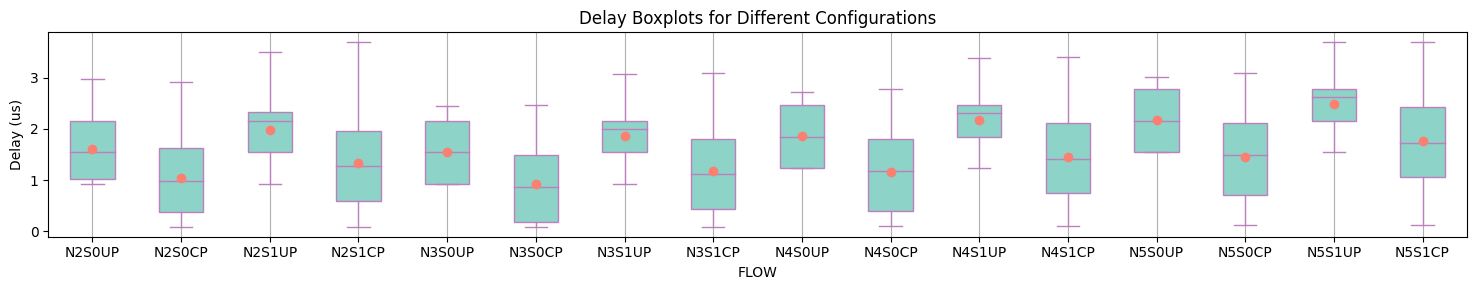

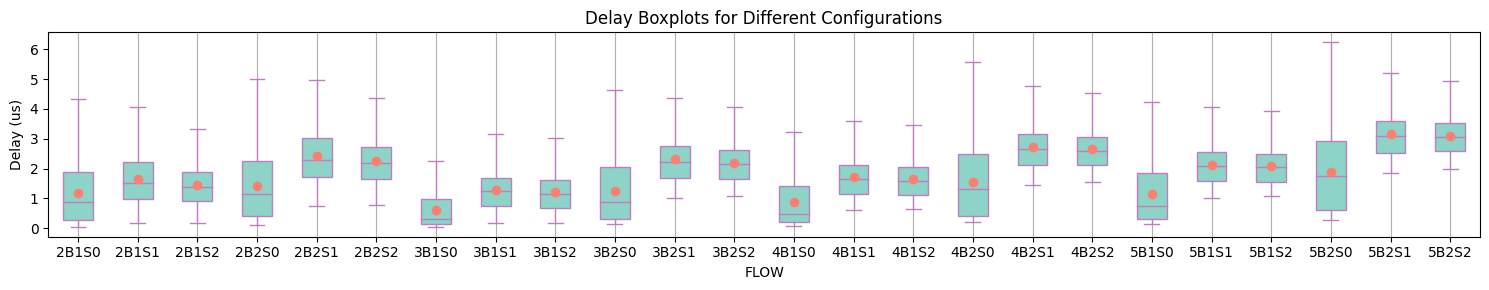

In [7]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
folder = "./sim_results/LinkDown/"
# Set a custom color palette
colors = plt.cm.Set3.colors
plt.rcParams["figure.autolayout"] = True
# Open the JSON file and load the data
with open("./scratch/hl4hl5ex.json") as json_file:
    data = json.load(json_file)
delay = []
# Access the data
folder_name = data["FolderName"]
enable_hqos = data["EnableHQoS"]


# Generate labels for boxplots
RUlabel = []
BHlabel = []
delay_slice = []
# Access Hl5Agreggration data
hl5_aggregation = data["Hl5Agreggration"]
for index, aggregation in enumerate(hl5_aggregation):
    print(f"HL5 node: {index}")
    sites = aggregation["Sites"]
    backhaul_enable = aggregation["Backhaulenable"]
    # Access more elements within Hl5Agreggration as needed...
    delay_user = []
    delay_control = []
    for site_index, site in enumerate(sites):
        cells = site["Cells"]
        cell_features = site["CellFeatures"]
        # Access more elements within Sites as needed...
        for cell_index, cell_feature in enumerate(cell_features):
            sitenum_global = site_index+2*index
            cellnum_global = cell_index+((index)*cells*len(sites)+ site_index*cells)
            # print(f"Sitenum: {sitenum_global } || Cellnum: {cellnum_global}")
            CTx = pd.read_csv(f"{folder}Site{site_index+1}TxFileControl{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            CRx = pd.read_csv(f"{folder}RxFileSite{site_index+1}Control{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            
            UTx = pd.read_csv(f"{folder}Site{site_index+1}TxFileUser{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            URx = pd.read_csv(f"{folder}RxFileSite{site_index+1}User{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                        # Calculate delay for user and control configurations
            min_len = min(len(UTx), len(URx))
            delay_user.append(URx["Time"].values[:min_len-1] - UTx["Time"].values[:min_len-1])
            min_len = min(len(CTx), len(CRx))
            delay_control.append(CRx["Time"].values[:min_len-1] - CTx["Time"].values[:min_len-1])
            # Assign values to the corresponding columns in the delay DataFrame
        # Access more elements within BHFeatures as needed...
        delay.append(np.concatenate(delay_user))
        delay.append(np.concatenate(delay_control))
        node_label = f"N{index+2}"
        site_label = f"S{site_index}"
        control_label = "CP"
        user_label = "UP"
        RUlabel.append(f"{node_label}{site_label}{user_label}")
        RUlabel.append(f"{node_label}{site_label}{control_label}")

    if backhaul_enable:
        bh_features = aggregation["BHFeatures"]
        slices = aggregation["Slices"]
        # Access more elements within Sites as needed...
        for bh in np.arange(1,3,1):
            for slice_index, _ in enumerate(bh_features):
                delay_flow = []
                flows = aggregation["FlowsPerSlice"]
                for  flow in  np.arange(0,flows,1):
                    # print(f"BH: {bh} - Slice: {slice_index} - N: {index*slices*flows + (slice_index)*flows + flow}" )
                    TxFlow = pd.read_csv(f"{folder}BH{bh}TxFile{index*slices*flows + (slice_index)*flows + flow}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                    RxFlow = pd.read_csv(f"{folder}RxFileBH{bh}_{index*slices*flows + (slice_index)*flows + flow}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                    min_len = min(len(TxFlow), len(RxFlow))
                    delay_flow.append(RxFlow["Time"].values[0:(min_len-1)] - TxFlow["Time"].values[0:(min_len-1)])
                delay_slice.append(np.concatenate(delay_flow))
                BHlabel.append(f"{index+2}B{bh}S{slice_index}")

# print("All done")
# Boxplot with enhanced style
delay_us = [arr*1e-9 for arr in delay]    



fig = plt.figure(figsize=(15,3))
bp = plt.boxplot(
    delay_us,
    labels= RUlabel,
    showmeans=True,
    showfliers=False,
    patch_artist=True,  # fill with color
    boxprops=dict(facecolor=colors[0], color=colors[9]),
    capprops=dict(color=colors[9]),
    whiskerprops=dict(color=colors[9]),
    flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
    medianprops=dict(color=colors[9]),
    meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
)

# Customize labels and title
plt.ylabel("Delay (us)")
plt.xlabel("FLOW")
plt.title("Delay Boxplots for Different Configurations")

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid()
plt.show()





BHdelay_us = [arr*1e-9 for arr in delay_slice]    
fig = plt.figure(figsize=(15,3))
bp = plt.boxplot(
    BHdelay_us,
    labels= BHlabel,
    showmeans=True,
    showfliers=False,
    patch_artist=True,  # fill with color
    boxprops=dict(facecolor=colors[0], color=colors[9]),
    capprops=dict(color=colors[9]),
    whiskerprops=dict(color=colors[9]),
    flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
    medianprops=dict(color=colors[9]),
    meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
)

# Customize labels and title
plt.ylabel("Delay (us)")
plt.xlabel("FLOW")
plt.title("Delay Boxplots for Different Configurations")

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid()
plt.show()






HL5 node: 0
HL5 node: 1
HL5 node: 2
HL5 node: 3


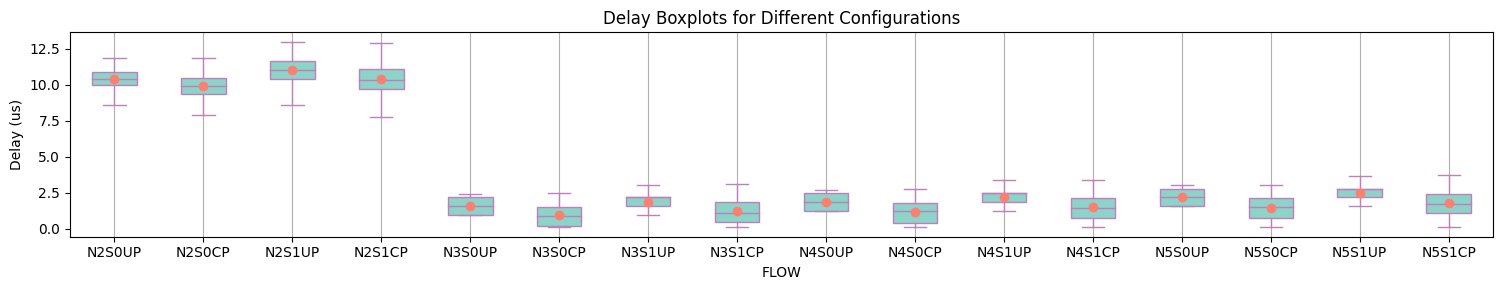

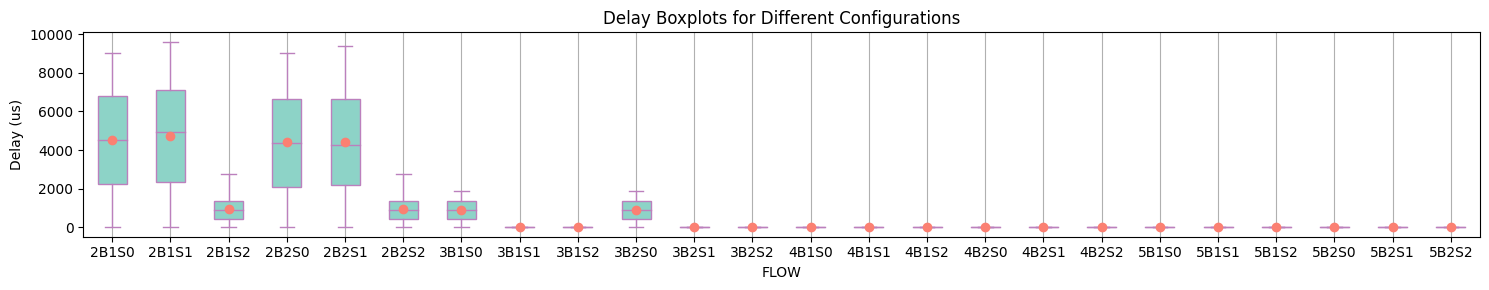

In [6]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
folder = "./sim_results/linkprueba/"
# Set a custom color palette
colors = plt.cm.Set3.colors
plt.rcParams["figure.autolayout"] = True
# Open the JSON file and load the data
with open("./scratch/hl4hl5ex.json") as json_file:
    data = json.load(json_file)
delay = []
# Access the data
folder_name = data["FolderName"]
enable_hqos = data["EnableHQoS"]


# Generate labels for boxplots
RUlabel = []
BHlabel = []
delay_slice = []
# Access Hl5Agreggration data
hl5_aggregation = data["Hl5Agreggration"]
for index, aggregation in enumerate(hl5_aggregation):
    print(f"HL5 node: {index}")
    sites = aggregation["Sites"]
    backhaul_enable = aggregation["Backhaulenable"]
    # Access more elements within Hl5Agreggration as needed...
    delay_user = []
    delay_control = []
    for site_index, site in enumerate(sites):
        cells = site["Cells"]
        cell_features = site["CellFeatures"]
        # Access more elements within Sites as needed...
        for cell_index, cell_feature in enumerate(cell_features):
            sitenum_global = site_index+2*index
            cellnum_global = cell_index+((index)*cells*len(sites)+ site_index*cells)
            # print(f"Sitenum: {sitenum_global } || Cellnum: {cellnum_global}")
            CTx = pd.read_csv(f"{folder}Site{site_index+1}TxFileControl{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            CRx = pd.read_csv(f"{folder}RxFileSite{site_index+1}Control{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            
            UTx = pd.read_csv(f"{folder}Site{site_index+1}TxFileUser{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            URx = pd.read_csv(f"{folder}RxFileSite{site_index+1}User{index*cells + cell_index}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                        # Calculate delay for user and control configurations
            min_len = min(len(UTx), len(URx))
            delay_user.append(URx["Time"].values[:min_len-1] - UTx["Time"].values[:min_len-1])
            min_len = min(len(CTx), len(CRx))
            delay_control.append(CRx["Time"].values[:min_len-1] - CTx["Time"].values[:min_len-1])
            # Assign values to the corresponding columns in the delay DataFrame
        # Access more elements within BHFeatures as needed...
        delay.append(np.concatenate(delay_user))
        delay.append(np.concatenate(delay_control))
        node_label = f"N{index+2}"
        site_label = f"S{site_index}"
        control_label = "CP"
        user_label = "UP"
        RUlabel.append(f"{node_label}{site_label}{user_label}")
        RUlabel.append(f"{node_label}{site_label}{control_label}")

    if backhaul_enable:
        bh_features = aggregation["BHFeatures"]
        slices = aggregation["Slices"]
        # Access more elements within Sites as needed...
        for bh in np.arange(1,3,1):
            for slice_index, _ in enumerate(bh_features):
                delay_flow = []
                flows = aggregation["FlowsPerSlice"]
                for  flow in  np.arange(0,flows,1):
                    # print(f"BH: {bh} - Slice: {slice_index} - N: {index*slices*flows + (slice_index)*flows + flow}" )
                    TxFlow = pd.read_csv(f"{folder}BH{bh}TxFile{index*slices*flows + (slice_index)*flows + flow}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                    RxFlow = pd.read_csv(f"{folder}RxFileBH{bh}_{index*slices*flows + (slice_index)*flows + flow}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                    min_len = min(len(TxFlow), len(RxFlow))
                    delay_flow.append(RxFlow["Time"].values[0:(min_len-1)] - TxFlow["Time"].values[0:(min_len-1)])
                delay_slice.append(np.concatenate(delay_flow))
                BHlabel.append(f"{index+2}B{bh}S{slice_index}")

# print("All done")
# Boxplot with enhanced style
delay_us = [arr*1e-9 for arr in delay]    



fig = plt.figure(figsize=(15,3))
bp = plt.boxplot(
    delay_us,
    labels= RUlabel,
    showmeans=True,
    showfliers=False,
    patch_artist=True,  # fill with color
    boxprops=dict(facecolor=colors[0], color=colors[9]),
    capprops=dict(color=colors[9]),
    whiskerprops=dict(color=colors[9]),
    flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
    medianprops=dict(color=colors[9]),
    meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
)

# Customize labels and title
plt.ylabel("Delay (us)")
plt.xlabel("FLOW")
plt.title("Delay Boxplots for Different Configurations")

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid()
plt.show()





BHdelay_us = [arr*1e-9 for arr in delay_slice]    
fig = plt.figure(figsize=(15,3))
bp = plt.boxplot(
    BHdelay_us,
    labels= BHlabel,
    showmeans=True,
    showfliers=False,
    patch_artist=True,  # fill with color
    boxprops=dict(facecolor=colors[0], color=colors[9]),
    capprops=dict(color=colors[9]),
    whiskerprops=dict(color=colors[9]),
    flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
    medianprops=dict(color=colors[9]),
    meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
)

# Customize labels and title
plt.ylabel("Delay (us)")
plt.xlabel("FLOW")
plt.title("Delay Boxplots for Different Configurations")

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid()
plt.show()




